# Technology focus: MibiTOF
This notebook will present a rough overview of the plotting functionalities that `spatialdata` implements for Visium data.

## Loading the data
Please download the data from here: [MIBI-TOF dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/mibitof.zip) and adjust the variable containing the location of the `.zarr` file.


In [1]:
mibitof_zarr_path = "./mibitof.zarr"

In [2]:
import spatialdata as sd

mibitof_sdata = sd.read_zarr(mibitof_zarr_path)
mibitof_sdata

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


SpatialData object with:
├── Images
│     ├── 'point8_image': SpatialImage[cyx] (3, 1024, 1024)
│     ├── 'point16_image': SpatialImage[cyx] (3, 1024, 1024)
│     └── 'point23_image': SpatialImage[cyx] (3, 1024, 1024)
├── Labels
│     ├── 'point8_labels': SpatialImage[yx] (1024, 1024)
│     ├── 'point16_labels': SpatialImage[yx] (1024, 1024)
│     └── 'point23_labels': SpatialImage[yx] (1024, 1024)
└── Table
      └── AnnData object with n_obs × n_vars = 3309 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'batch', 'library_id'
    uns: 'spatialdata_attrs'
    obsm: 'X_scanorama', 'X_umap', 'spatial': AnnData (3309, 36)
with coordinate systems:
▸ 'point8', with elements:
        point8_image (Images), point8_labels (Labels)
▸ 'point16', with elements:
        point16_image (Images), point16_labels (Labels)
▸ 'point23', with elements:
        point23_image (Images), point23_labels (Labels)

## Visualise the data
We're going to create a naiive visualisation of the data, overlaying the segmented cells and the tissue images. For this, we need to load the `spatialdata_plot` library which extends the `sd.SpatialData` object with the `.pl` module. 

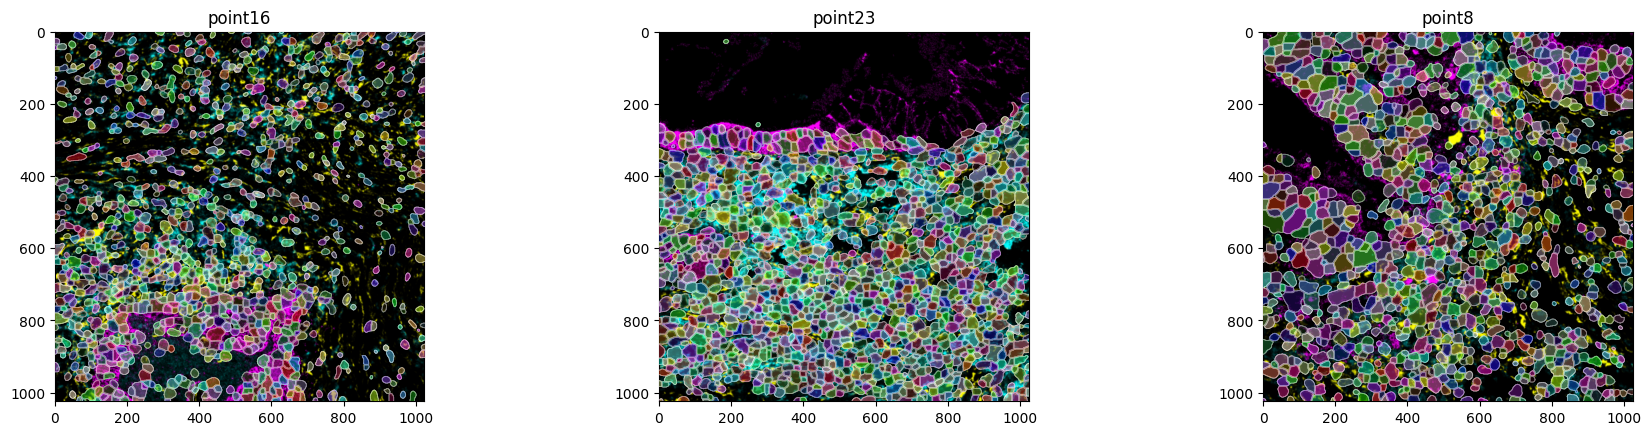

In [3]:
import spatialdata_plot

mibitof_sdata.pl.render_images().pl.render_labels().pl.show()

We can see that the data contains three coordinate systems (`point8`, `point16` and `point23`) with image and cell segmentation information each. When giving no further parameters, one panel is generated per coordinate system with the members that have been specified in the function call. While it is hard to see, the cell labels overlay the tissue image nicely. To better show this, we will plot the data on individual `ax` objects.

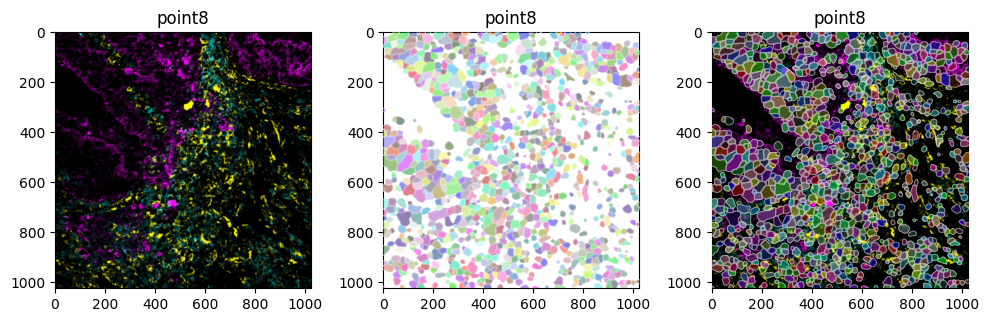

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4))

mibitof_sdata_subset = mibitof_sdata.pp.get_elements("point8")

mibitof_sdata_subset.pl.render_images().pl.show(ax=axs[0])

mibitof_sdata_subset.pl.render_labels().pl.show(ax=axs[1])

mibitof_sdata_subset.pl.render_images().pl.render_labels().pl.show(ax=axs[2])

plt.tight_layout()


However, the segmentation masks are all shown in random colors since we have not provided any information on what they should encode. Such information can be found in the `Table` attribute (which is an `anndata.AnnData` table) of the `SpatialData` object,either in the data itself or the `obs` attribute.

In [5]:
mibitof_sdata.table.to_df().head(3)

,ASCT2,ATP5A,CD11c,CD14,CD3,CD31,CD36,CD39,CD4,CD45,...,NRF2p,NaKATPase,PD1,PKM2,S6p,SDHA,SMA,VDAC1,XBP1,vimentin
9376-1,-0.099024,0.047260,-0.076592,-0.160894,-0.094239,-0.059072,-0.048790,-0.080359,-0.181162,-0.177686,...,-0.063972,-0.062695,-0.078785,-0.189159,-0.233837,0.038624,-0.502865,-0.016736,0.055549,-0.410221
9377-1,-0.081413,0.025841,-0.062929,0.071132,-0.086687,-0.072516,0.209030,0.067253,0.088813,-0.164108,...,0.116562,0.115541,-0.075863,0.024126,-0.318994,-0.043148,-0.120517,-0.058352,-0.197411,-0.179946
9378-1,-0.100959,-0.203419,-0.055992,-0.134076,-0.066981,-0.047282,-0.044181,-0.170404,-0.045016,-0.110186,...,-0.031722,-0.109969,-0.060554,-0.244716,-0.218434,-0.172760,-0.301259,-0.210778,0.042039,-0.266521


In [6]:
mibitof_sdata.table.obs.head(3)

,row_num,point,cell_id,X1,center_rowcoord,center_colcoord,cell_size,category,donor,Cluster,batch,library_id
9376-1,9479,8,2,65222.0,37.0,6.0,474.0,carcinoma,90de,Epithelial,1,point8_labels
9377-1,9480,8,4,65224.0,314.0,3.0,126.0,carcinoma,90de,Epithelial,1,point8_labels
9378-1,9481,8,5,65225.0,407.0,6.0,398.0,carcinoma,90de,Epithelial,1,point8_labels


### Color the segmentation masks by a categorical variable
To use this information in our plot, we provide the column-name to be used for the color-enocoding to  `color` in `render_labels()`. Here, `spatialdata-plot` automatically differentiates between categorical and numerical columns. Furthermore, we subset the data to only one coordinate system.

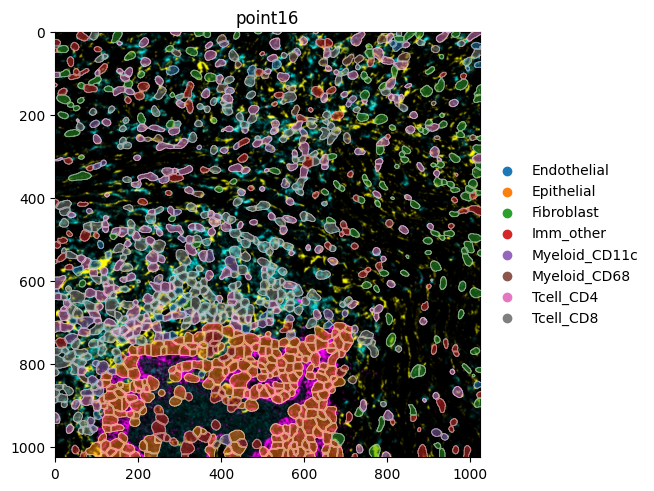

In [7]:
(mibitof_sdata.pp.get_elements("point16").pl.render_images().pl.render_labels(color="Cluster").pl.show())

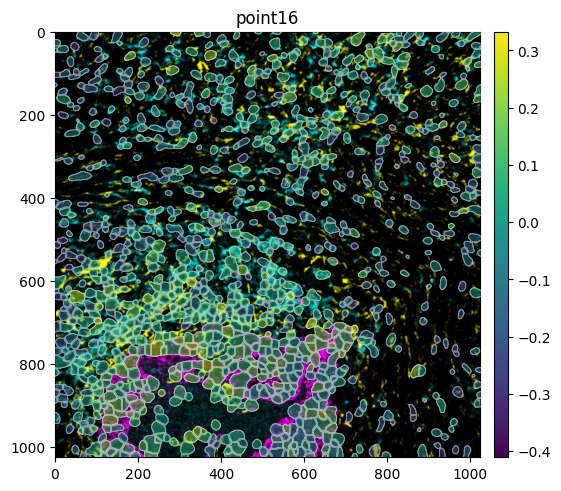

In [8]:
(mibitof_sdata.pp.get_elements("point16").pl.render_images().pl.render_labels(color="ASCT2").pl.show())